In [1]:
import pandas as pd
import prototype as pt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

c:\users\kobyl\anaconda3\envs\anomaly\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


[]


In [2]:
path_to_data = 'D:\\ubuntu\\zephyr_data\\'

In [8]:
import hashlib

def saveSnippetIntoFile(snippet):
    m = hashlib.sha256()
    m.update(snippet.encode('utf-8'))
    snippet_filename = m.hexdigest() + '.py'
    path_to_file = 'nested_snippets_files\\' + snippet_filename
    
    with open(path_to_data + path_to_file, 'w', encoding='utf-8') as f:
        f.write(snippet)
        f.close()
    return path_to_file

# Вычисление A-индекса

Для случайной подвыборки кода длины 10000 вычислим А-индекс.

In [3]:
import pickle5 as pickle

pickle_file = open(path_to_data + 'nested_code\\nested_code.pickle','rb')
data = pickle.load(pickle_file)

In [11]:
data['path_to_file'] = data['snippet source code'].apply(saveSnippetIntoFile)

In [12]:
anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
                                            for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'nested_snippets_files\\'))], 
                                            columns =['a-index', 'path_to_file', 'message'])
df = data.join(anomaly_results.set_index('path_to_file'), on='path_to_file')

# Связь степени вложенности кода и А-индекса
Посмотрим на корреляцию между уровнем вложенности кода и А-индексом для достаточно больших значений вложенности.

In [77]:
df.loc[df['nesting_level'] > 1, ['nesting_level', 'a-index']].corr(method='spearman')

,nesting_level,a-index
nesting_level,1.000000,0.724684
a-index,0.724684,1.000000


In [15]:
import seaborn as sb
import matplotlib.pyplot as plt

Теперь построим графики

<AxesSubplot:xlabel='nesting_level', ylabel='a-index'>

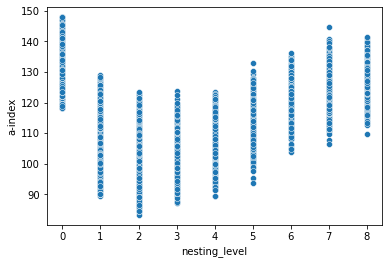

In [16]:
sb.scatterplot(x='nesting_level',
               y='a-index',
               data=df)

# Анализ связи А-индекса с частотой часто встречающихся токенов

In [18]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [19]:
from collections import Counter

df['max_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x.most_common(1)[0][1])
df['max_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x['Ġ'])

Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


Видно, что частоты часто встречающихся токенов достаточно сильно коррелированы с А-индексом.

In [20]:
df[['a-index', 'max_token_occurence', 'max_G_token_occurence']].corr(method='spearman')

,a-index,max_token_occurence,max_G_token_occurence
a-index,1.000000,-0.570393,-0.570393
max_token_occurence,-0.570393,1.000000,1.000000
max_G_token_occurence,-0.570393,1.000000,1.000000


Построим диаграмму рассеяния.

In [21]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

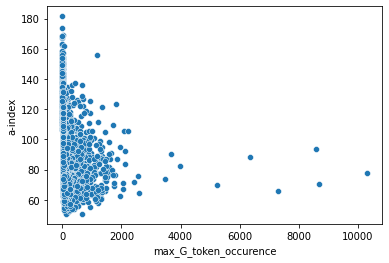

In [68]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df)

Уберем выбросы и снова построим

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

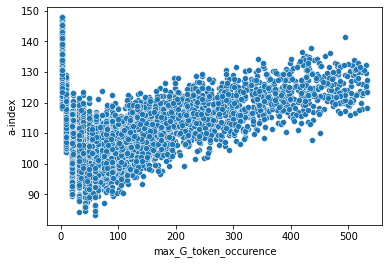

In [22]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)])

Подсчитаем корреляцию.

In [35]:
df.loc[(df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)) &
       (df['max_G_token_occurence'] > 50), 
       ['max_G_token_occurence', 'a-index']].corr(method='spearman')

,max_G_token_occurence,a-index
max_G_token_occurence,1.000000,0.755031
a-index,0.755031,1.000000


# Анализ связи А-индекса с частотой подряд идущих токенов

Напишем функции для вычисления наибольших частот подряд идущих токенов.

In [36]:
from itertools import groupby

def computeMaxRepetitiveTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    return sorted(token_occurences, key=lambda x: x[1])[-1][1]

In [37]:
def computeMaxRepetitiveGTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    
    max_count = 0
    for token, count in sorted(token_occurences, key=lambda x: x[1]):
        if token == 'Ġ':
            max_count = max(max_count, count)    
    return max_count

Вычислим эти частоты.

In [38]:
df['max_consequtive_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveTokenSequenceLength)
df['max_consequtive_G_token_occurence'] = df['snippet source code'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveGTokenSequenceLength)

Подсчитаем корреляции.

In [39]:
df[['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.561253,-0.561253
max_consequtive_token_occurence,-0.561253,1.000000,1.000000
max_consequtive_G_token_occurence,-0.561253,1.000000,1.000000


Посмотрим на графики

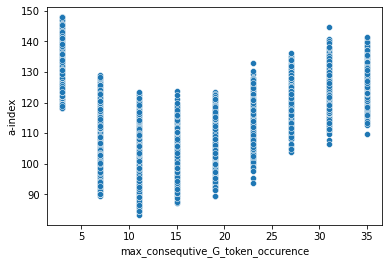

In [40]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df);

Посмотрим на связь с А-индексом при частоте символа G больше 10:

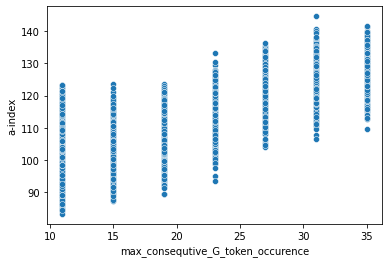

In [41]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] >= 10]);

Подсчитаем также корреляции по этой подвыборке

In [42]:
df.loc[df['max_consequtive_G_token_occurence'] >= 10][['a-index', 'max_consequtive_token_occurence', 
                                                       'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,0.724684,0.724684
max_consequtive_token_occurence,0.724684,1.000000,1.000000
max_consequtive_G_token_occurence,0.724684,1.000000,1.000000


Оценим какова длина этой подвыборки

In [43]:
df.loc[df['max_consequtive_G_token_occurence'] >= 10].shape[0] / 10000 * 100

43.71

Посмотрим на связь А-индекса с частотой для малых значений наибольшей частоты подряд идущих символов:

<AxesSubplot:xlabel='max_consequtive_G_token_occurence', ylabel='a-index'>

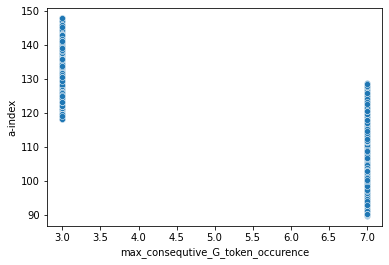

In [44]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] < 10])

Оценим соответствующую корреляцию

In [45]:
df.loc[df['max_consequtive_G_token_occurence'] < 10][['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.805781,-0.805781
max_consequtive_token_occurence,-0.805781,1.000000,1.000000
max_consequtive_G_token_occurence,-0.805781,1.000000,1.000000


# Выводы

- частоты символа G отрицательно коррелированы с А-индексом;
- для достаточно больших значений этих частот они положительно коррелированы с А-индексом;
- частоты подряд идущего символа G отрицательно коррелированы с А-индексом;
- для достаточно больших значений этих частот они положительно коррелированы с А-индексом.

# Анализ связи А-индекса с некоторыми метриками кода

In [46]:
from radon.visitors import ComplexityVisitor
from radon.complexity import cc_rank
from radon.metrics import h_visit, mi_visit
from radon.raw import analyze
import numpy as np

Функции вычисления метрик

In [47]:
def computeCyclomaticComplexity(snippet):
    return ComplexityVisitor.from_code(snippet).functions_complexity

In [48]:
def computeHastadMetrics(snippet):
    hastad_metrics = h_visit(snippet).total
    return {metric:getattr(hastad_metrics, metric) for metric in dir(hastad_metrics) 
            if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}

In [49]:
def computeRawMetrics(snippet):
    try:
        raw_metrics = analyze(snippet)
        return {metric:getattr(raw_metrics, metric) for metric in dir(raw_metrics) 
                if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}
    except SyntaxError:
        return None

In [50]:
def computeMIindex(snippet):
    try:
        return mi_visit(snippet, multi=False)
    except SyntaxError:
        return np.nan

# Подсчет метрик

## Цикломатическая сложность

In [51]:
df['cc'] = df['snippet source code'].apply(computeCyclomaticComplexity)

## Метрики Хастада

In [52]:
hastad_metrics = df['snippet source code'].apply(computeHastadMetrics)

In [53]:
for col in hastad_metrics.loc[0].keys():
    df[col] = hastad_metrics.apply(lambda x: x[col])

## Сырые метрики

In [54]:
raw_metrics = df['snippet source code'].apply(computeRawMetrics)

In [55]:
for col in raw_metrics.loc[0].keys():
    df[col] = raw_metrics.apply(lambda x: x[col] if x else np.nan)

## Индекс качества кода

In [56]:
df['MI'] = df['snippet source code'].apply(computeMIindex)

# Связь с метриками

Формируем список всех метрик.

In [57]:
metric_names = ['cc', 'N1', 'N2', 'bugs', 'calculated_length', 'difficulty',
                'effort', 'h1', 'h2', 'length', 'time', 'vocabulary', 
                'volume', 'blank', 'comments', 'lloc', 'loc', 'multi',
                'single_comments', 'sloc', 'MI']

In [58]:
pd.set_option('display.max_columns', 500)

Подсчитаем корреляции

In [59]:
df[metric_names + ['a-index']].corr(method='spearman').round(2)

,cc,N1,N2,bugs,calculated_length,difficulty,effort,h1,h2,length,time,vocabulary,volume,blank,comments,lloc,loc,multi,single_comments,sloc,MI,a-index
cc,1.00,0.90,0.90,0.90,0.90,0.89,0.90,0.89,0.90,0.90,0.90,0.90,0.90,NaN,NaN,0.99,0.99,NaN,NaN,0.99,-0.91,-0.57
N1,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
N2,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
bugs,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
calculated_length,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
difficulty,0.89,0.99,0.99,0.99,0.99,1.00,1.00,1.00,0.99,0.99,1.00,0.99,0.99,NaN,NaN,0.88,0.88,NaN,NaN,0.88,-0.98,-0.43
effort,0.90,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
h1,0.89,0.99,0.99,0.99,0.99,1.00,1.00,1.00,0.99,0.99,1.00,1.00,0.99,NaN,NaN,0.88,0.88,NaN,NaN,0.88,-0.98,-0.43
h2,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42
length,0.90,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,NaN,NaN,0.89,0.89,NaN,NaN,0.89,-0.99,-0.42


Подсчитаем корреляции для достаточно больших значений цикломатической сложности:

In [61]:
df.loc[df['cc'] >= 2, metric_names + ['a-index']].corr(method='spearman').round(2)

,cc,N1,N2,bugs,calculated_length,difficulty,effort,h1,h2,length,time,vocabulary,volume,blank,comments,lloc,loc,multi,single_comments,sloc,MI,a-index
cc,1.00,0.84,0.84,0.83,0.83,0.80,0.83,0.79,0.83,0.84,0.83,0.83,0.83,NaN,NaN,0.95,0.95,NaN,NaN,0.95,-0.94,0.68
N1,0.84,1.00,1.00,0.99,0.99,0.95,0.99,0.95,0.99,1.00,0.99,0.99,0.99,NaN,NaN,0.80,0.80,NaN,NaN,0.80,-0.93,0.58
N2,0.84,1.00,1.00,0.99,0.99,0.95,0.99,0.95,0.99,1.00,0.99,0.99,0.99,NaN,NaN,0.80,0.80,NaN,NaN,0.80,-0.93,0.58
bugs,0.83,0.99,0.99,1.00,1.00,0.95,0.99,0.96,0.99,0.99,0.99,1.00,1.00,NaN,NaN,0.80,0.80,NaN,NaN,0.80,-0.93,0.57
calculated_length,0.83,0.99,0.99,1.00,1.00,0.94,0.98,0.96,1.00,0.99,0.98,1.00,1.00,NaN,NaN,0.79,0.79,NaN,NaN,0.79,-0.92,0.56
difficulty,0.80,0.95,0.95,0.95,0.94,1.00,0.98,0.98,0.92,0.95,0.98,0.94,0.95,NaN,NaN,0.76,0.76,NaN,NaN,0.76,-0.89,0.55
effort,0.83,0.99,0.99,0.99,0.98,0.98,1.00,0.97,0.97,0.99,1.00,0.98,0.99,NaN,NaN,0.80,0.80,NaN,NaN,0.80,-0.92,0.57
h1,0.79,0.95,0.95,0.96,0.96,0.98,0.97,1.00,0.94,0.95,0.97,0.97,0.96,NaN,NaN,0.76,0.76,NaN,NaN,0.76,-0.89,0.54
h2,0.83,0.99,0.99,0.99,1.00,0.92,0.97,0.94,1.00,0.99,0.97,1.00,0.99,NaN,NaN,0.79,0.79,NaN,NaN,0.79,-0.92,0.56
length,0.84,1.00,1.00,0.99,0.99,0.95,0.99,0.95,0.99,1.00,0.99,0.99,0.99,NaN,NaN,0.80,0.80,NaN,NaN,0.80,-0.93,0.58


Вычислим медианные значения А-индекса при фиксированном значении метрик:

In [62]:
def groupedTargetMedian(data, 
                        feature_name, 
                        feature_value,
                        feature_std,
                        target_name):
    return data.loc[(data[feature_name] > feature_value - 0.1 * feature_std) &
                    (data[feature_name] < feature_value + 0.1 * feature_std), target_name].median(axis=0)

In [63]:
stds = df[metric_names].std(axis=0)

for metric_name in metric_names:
    df['a-index median given ' + metric_name + ' value'] = df[metric_name].apply(lambda x: 
                                                                                 groupedTargetMedian(df,
                                                                                                     metric_name,
                                                                                                     x,
                                                                                                     stds[metric_name],
                                                                                                     'a-index'))

Функция рисования графиков.

In [64]:
def plotScatterPlots(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.scatterplot(x=var_name, y='a-index', data=data)
            sb.scatterplot(x=var_name, y='a-index median given ' + var_name + ' value', data=data)
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показаны диаграммы рассеяния между А-индексом и метрикой, а также между медианой А-индекса и метрикой. Для более явной картины убрали выбросы.

In [65]:
df.loc[df['N1'] <= 100].shape[0] / df.shape[0] * 100

100.0

Показываются переменные 0 to 5 ...


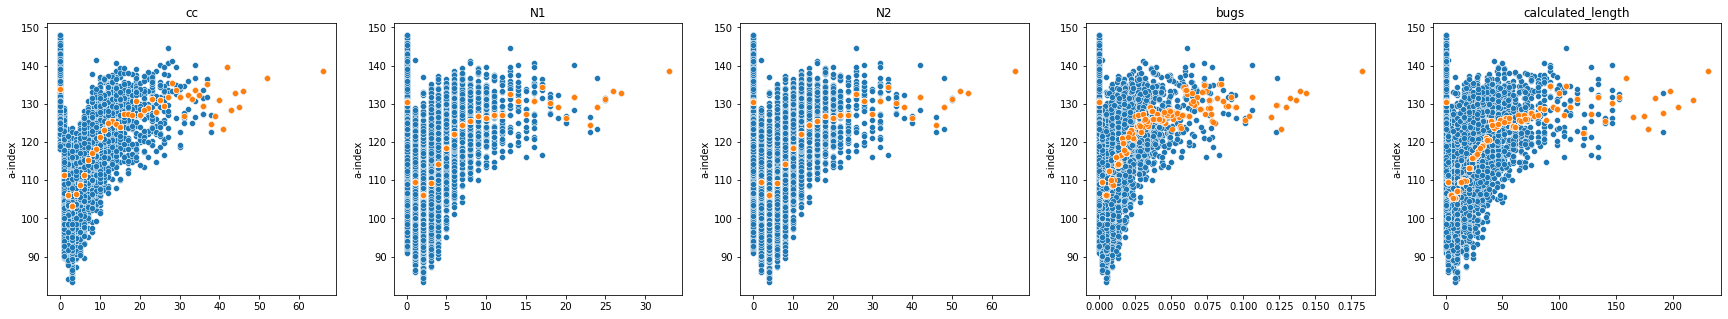

Показываются переменные 5 to 10 ...


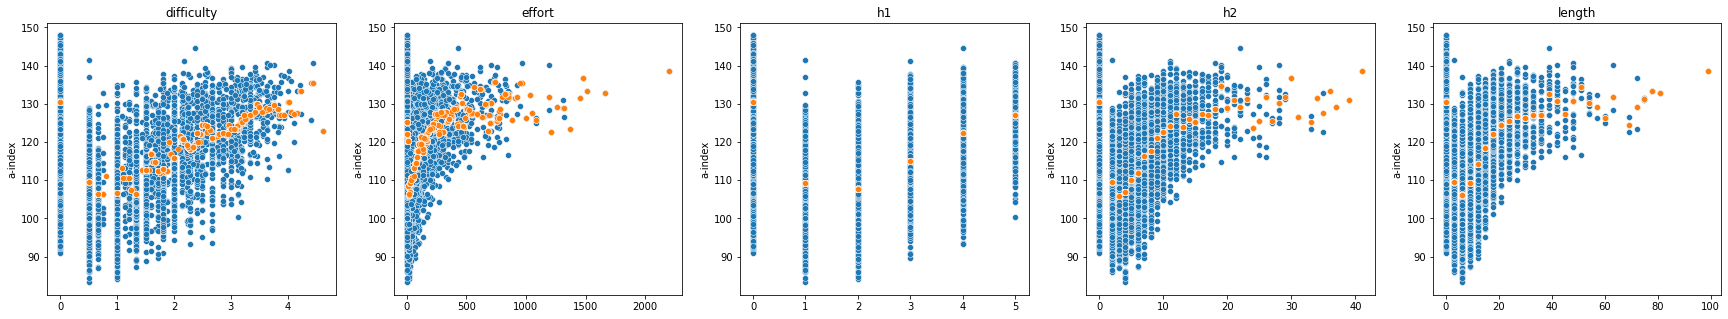

Показываются переменные 10 to 15 ...


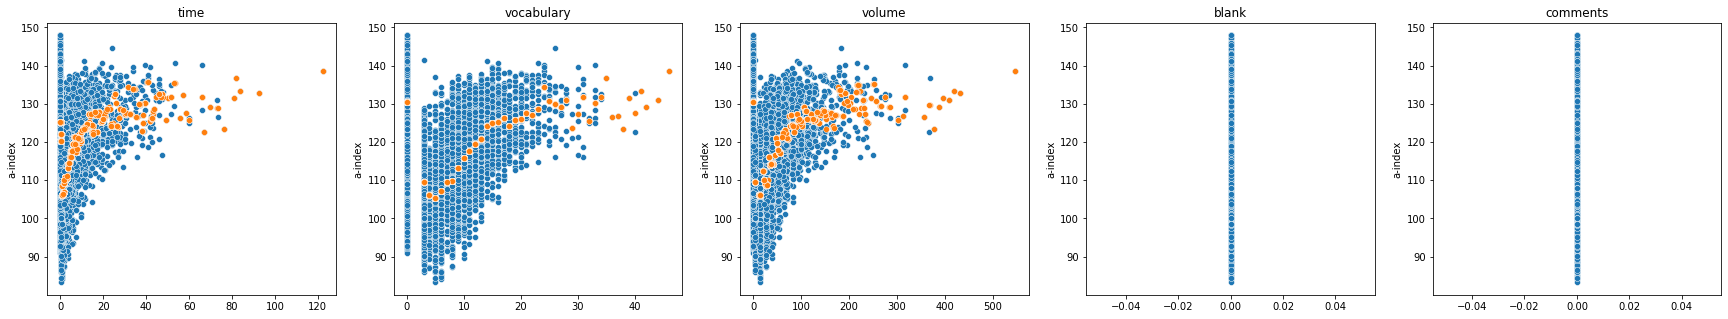

Показываются переменные 15 to 20 ...


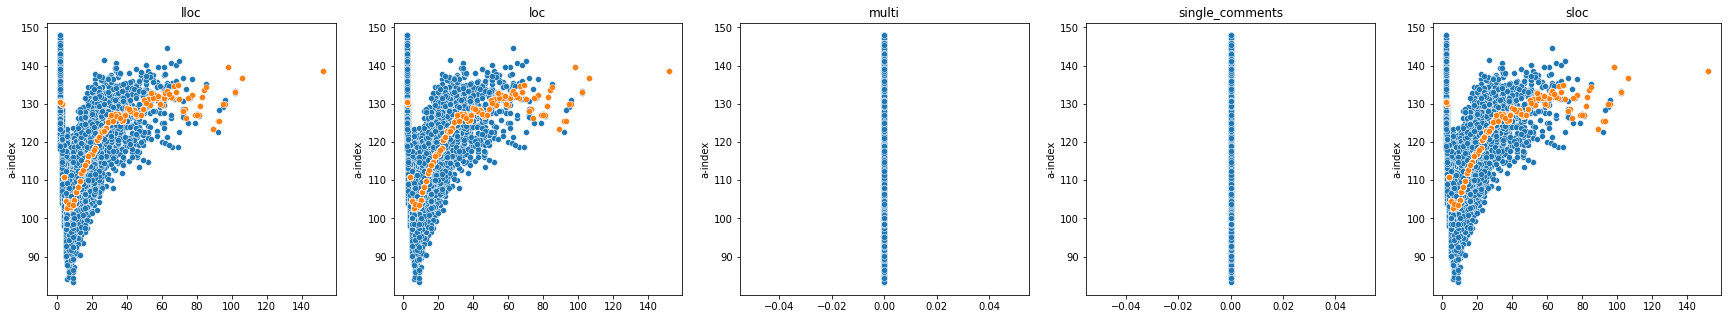

Показываются переменные 20 to 25 ...


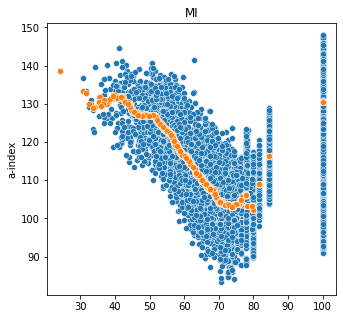

In [66]:
plotScatterPlots(df.loc[df['N1'] <= 100], metric_names)

In [69]:
def plotHistograms(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.histplot(x=var_name, data=data, bins=100,
                        stat='count')
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показываются переменные 0 to 5 ...


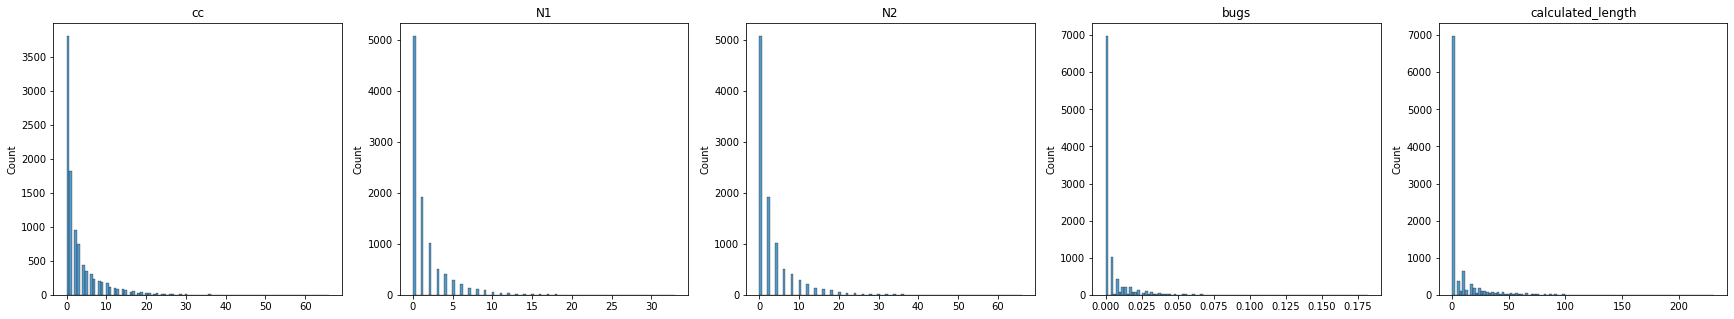

Показываются переменные 5 to 10 ...


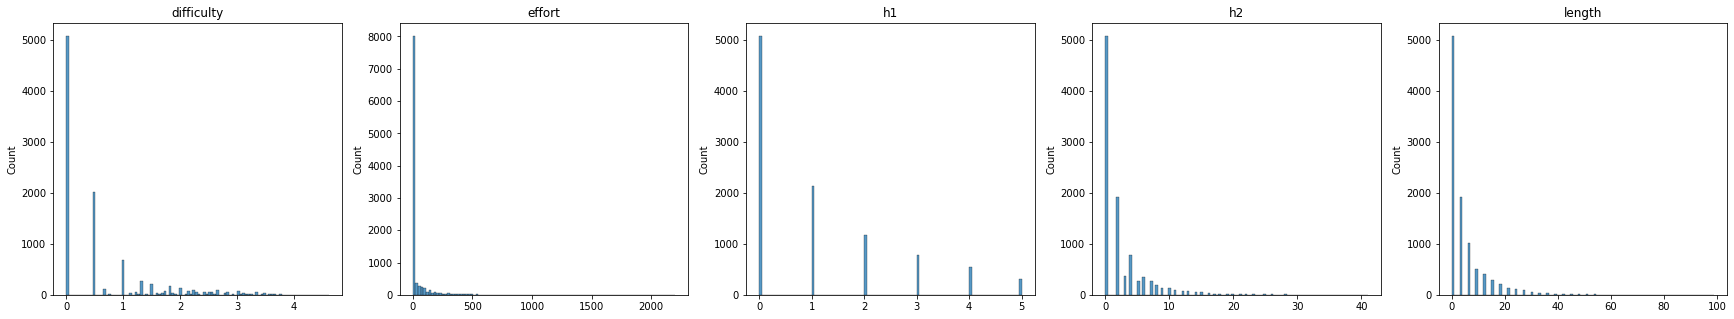

Показываются переменные 10 to 15 ...


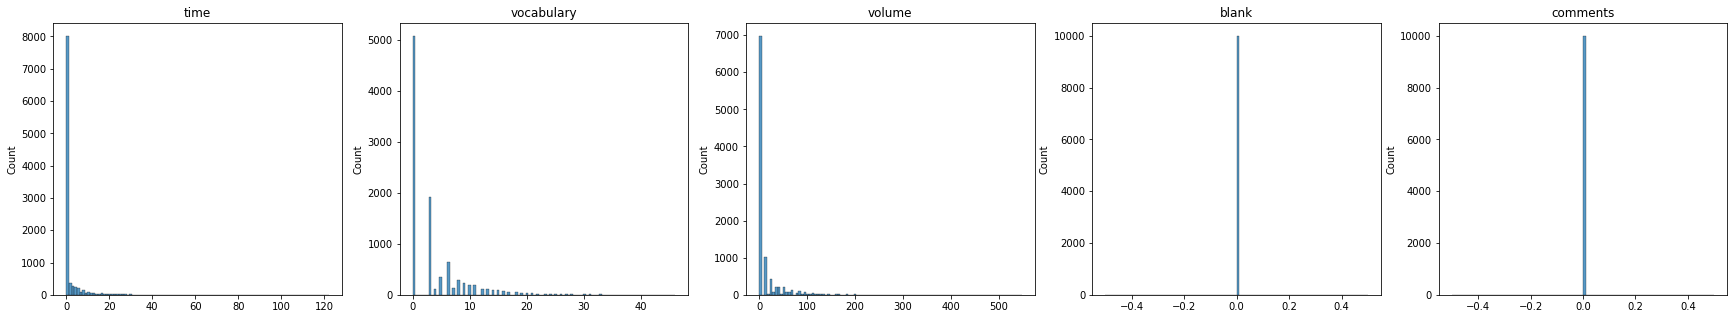

Показываются переменные 15 to 20 ...


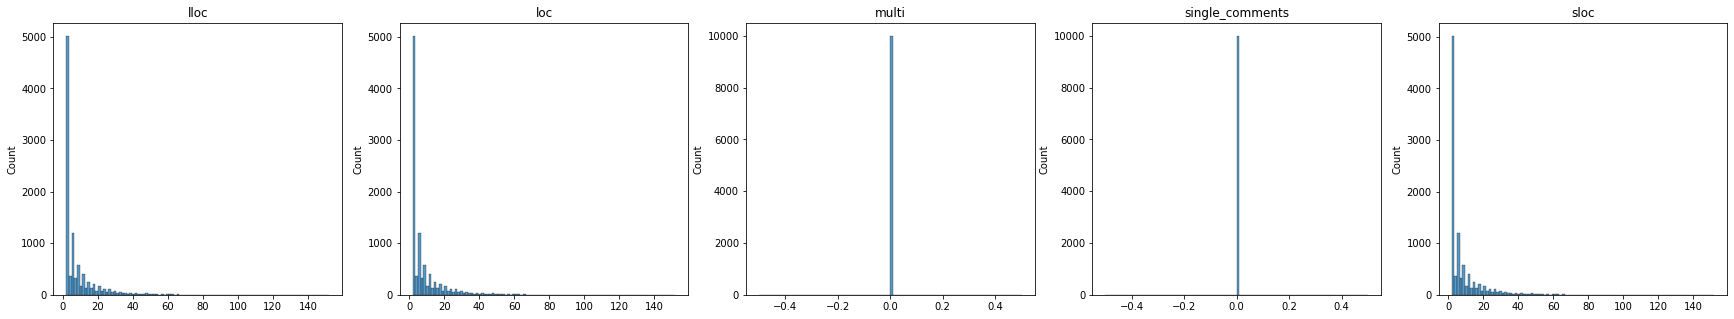

Показываются переменные 20 to 25 ...


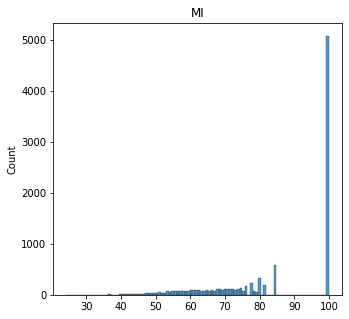

In [70]:
plotHistograms(df.loc[df['N1'] <= 100], metric_names);

# Выводы

- при росте значений метрик разброс аномальности быстро уменьшается за счет того что количество сниппетов с ростом значения метрик быстро убывает;
- для сниппетов малой длины и сложности разброс значений аномальности велик, среди них много аномальных сниппетов;
- для малых значений метрик (кроме MI) А-индекс уменьшается с ростом значений метрик, а потом для достаточно больших значений он растет в ответ на увеличение значений метрик.

Посмотрим на связь метрик и аномальности для очень малых значений метрик, для которых достаточно много сниппетов.

Показываются переменные 0 to 5 ...


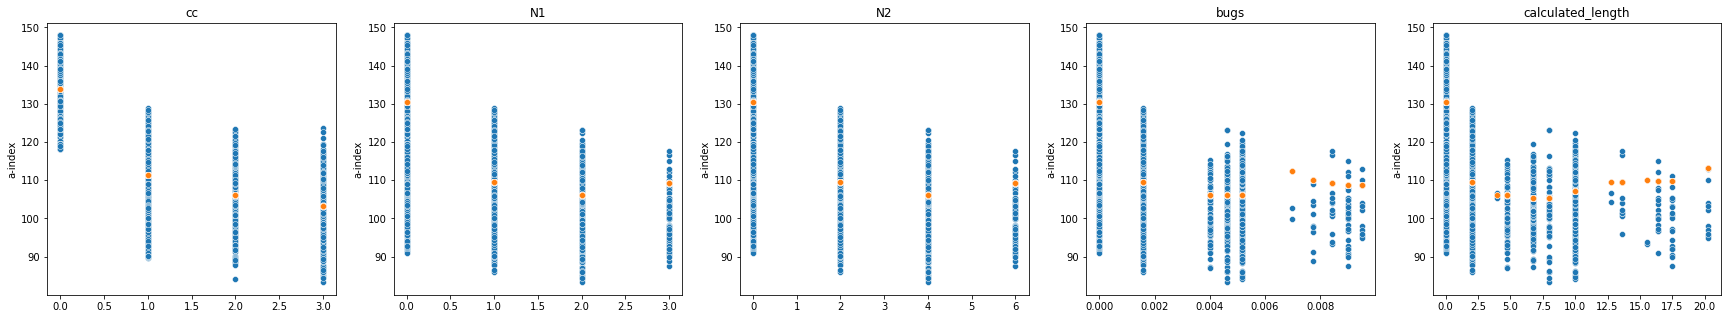

Показываются переменные 5 to 10 ...


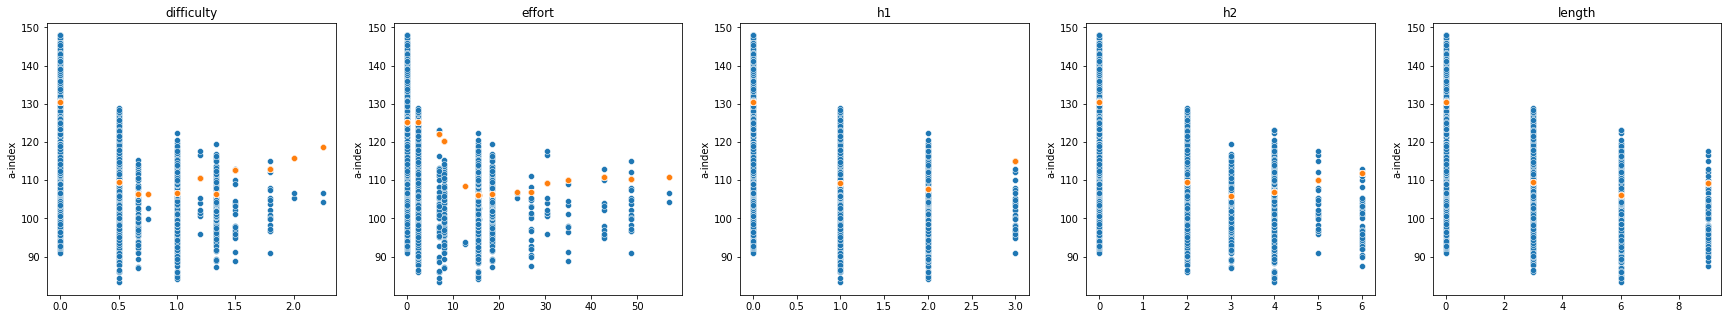

Показываются переменные 10 to 15 ...


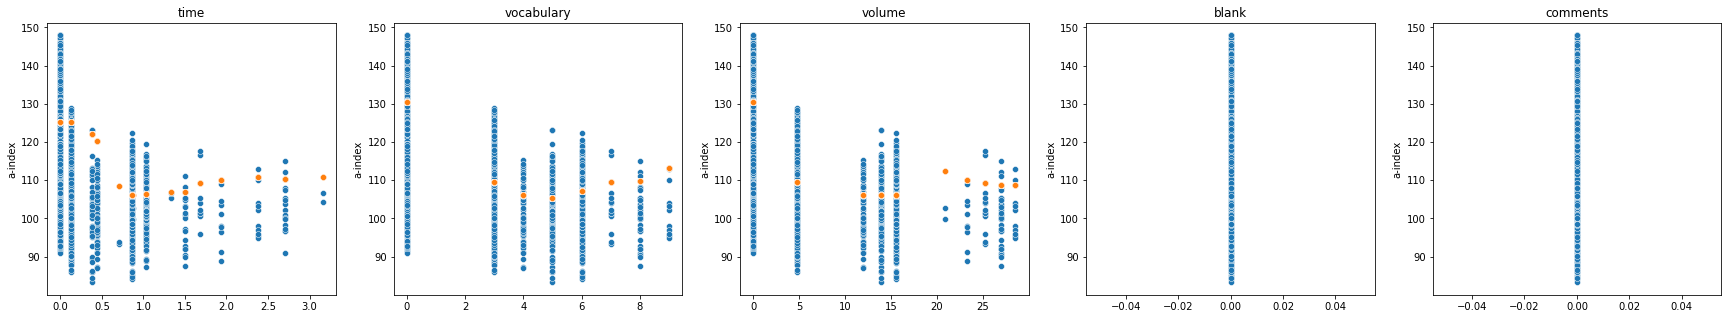

Показываются переменные 15 to 20 ...


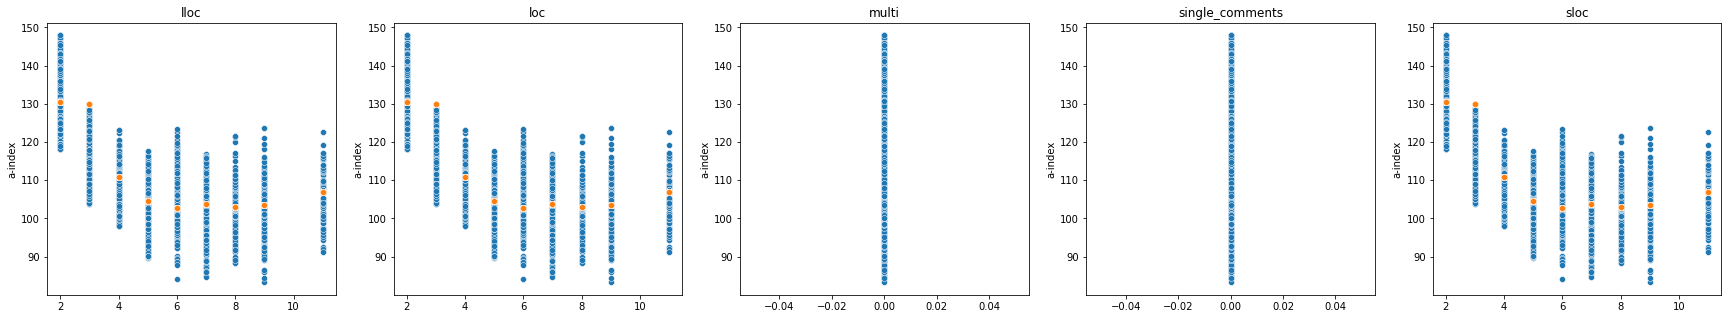

Показываются переменные 20 to 25 ...


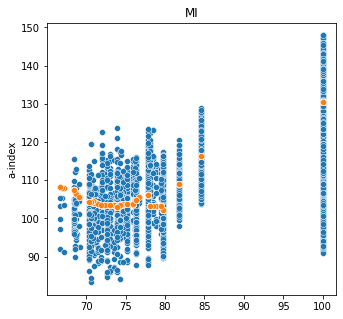

In [71]:
plotScatterPlots(df.loc[df['cc'] <= 3], metric_names)

Теперь для достаточно больших значений метрик.

Показываются переменные 0 to 5 ...


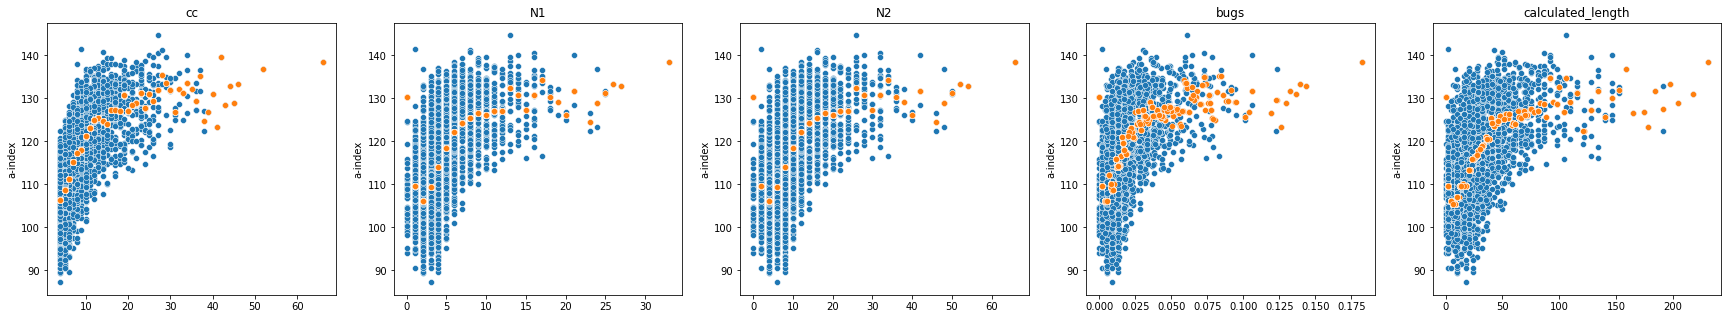

Показываются переменные 5 to 10 ...


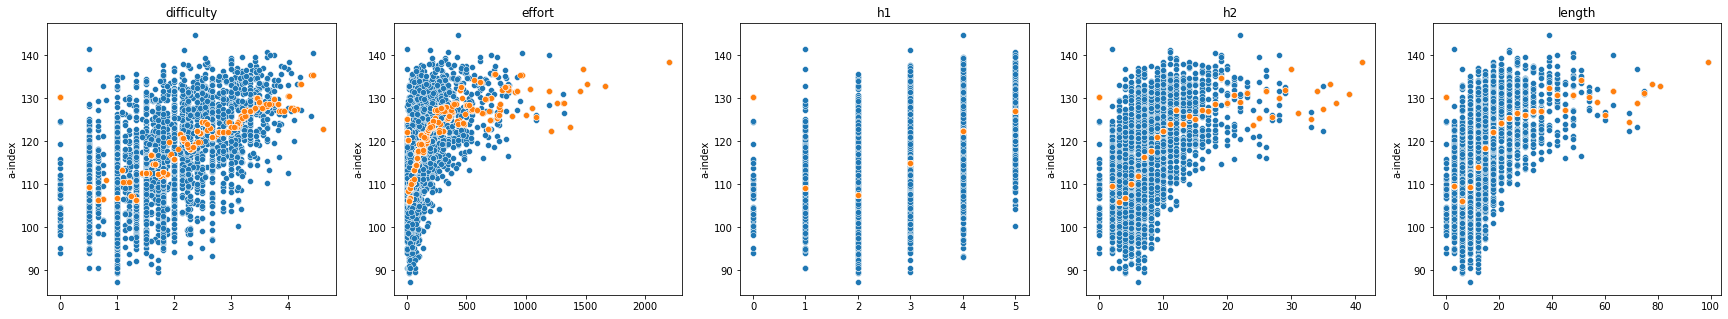

Показываются переменные 10 to 15 ...


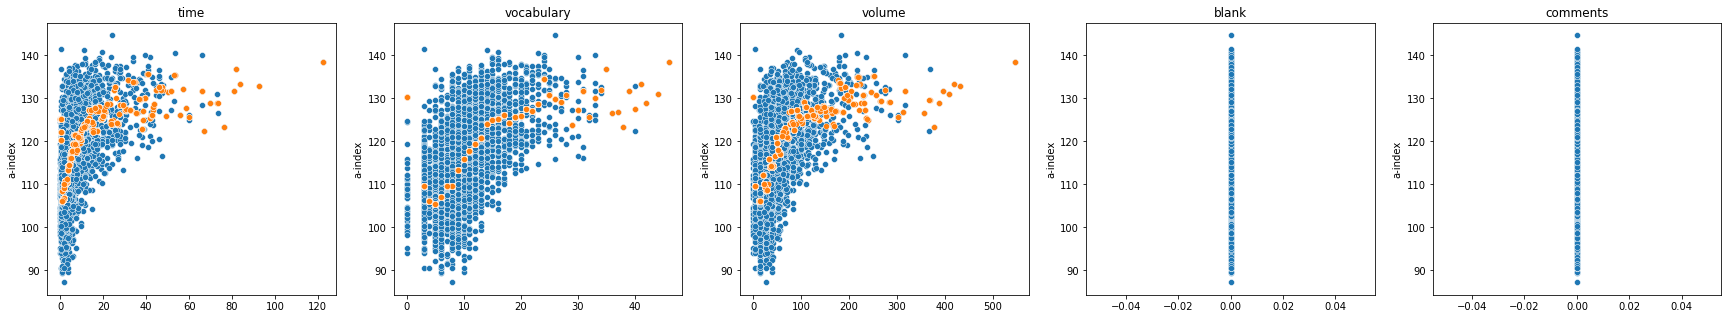

Показываются переменные 15 to 20 ...


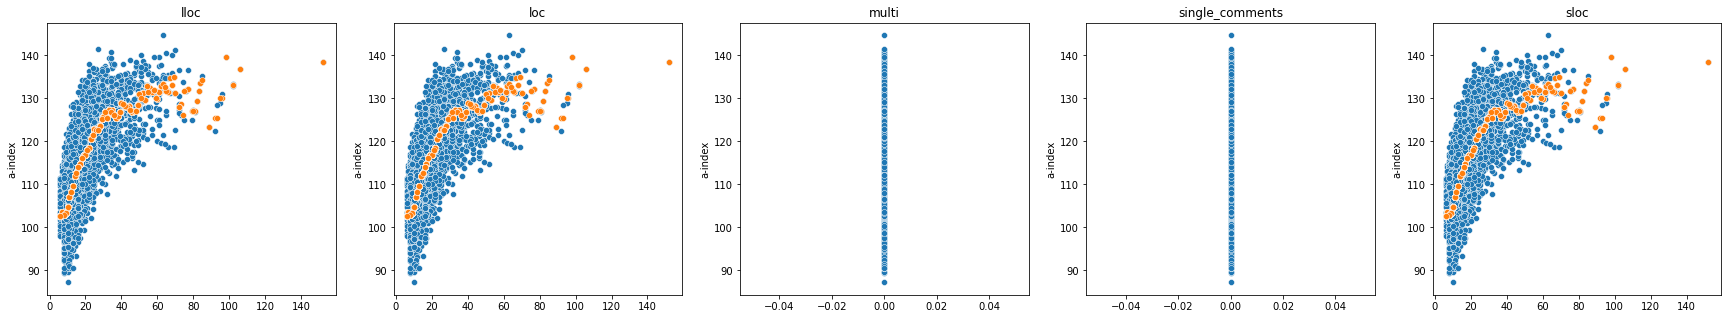

Показываются переменные 20 to 25 ...


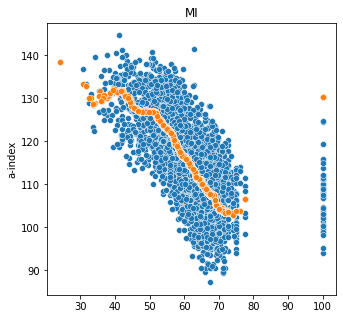

In [72]:
plotScatterPlots(df.loc[df['cc'] > 3], metric_names)

# Выводы

Выводы примерно такие же как и в предыдущем разделе.

# Анализ распределения А-индекса

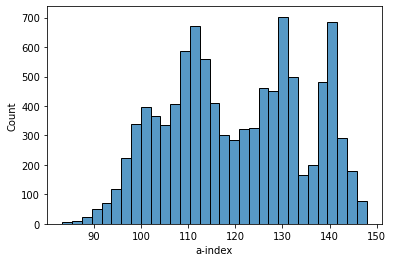

In [73]:
sb.histplot(x='a-index', data=df);

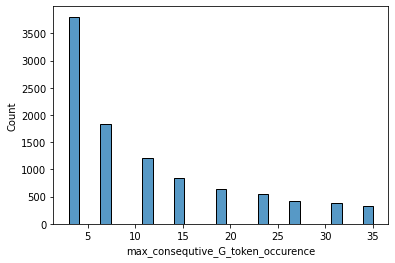

In [74]:
sb.histplot(x='max_consequtive_G_token_occurence', data=df);

# Выводы

Распределение А-индекса на синтетически сгенерированном коде - многомодальное. Одна из мод соответствует короткому коду, а вторая - коду с высокой вложенностью.

# Анализ распределения А-индекса для короткого кода

In [1]:
sb.histplot(x='a-index', data=df.loc[df['loc'] <=2], label='короткий код', color='r');
sb.histplot(x='a-index', data=df, label='весь код', color='g');
plt.legend();

NameError: name 'sb' is not defined

Вмдно что короткий код имеет более высокий А-индекс.